In [21]:
# %matplotlib notebook
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.figure as fig
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
from datetime import datetime as dt
from dateutil.parser import parse
import re

In [22]:
# we only want the interval data from a single agency
# other ones for NM:  32000-2, 32000-3, 32000-901, 32000-4, 32000-61, 32000-8, 32000-9, 32000-18
# NC:  34003-31, 34003-32, 34003-35, ...
agency = "34003-32"
# read the file in chunks, then append only the data that matches that agency
print(dt.now())
iter_csv = pd.read_csv('data/intervals.csv', iterator=True, chunksize=1000)
df = pd.concat([chunk[chunk['uniquename'] == agency] for chunk in iter_csv])
print(dt.now())

2019-02-13 17:09:31.825853
2019-02-13 17:09:49.618527


In [23]:
# add a new column which is the timestamp as a datetime object
df['ts'] = df.apply(lambda row: parse(row.timestamp), axis=1)

# add a new column for the hour of the day
df['HR'] = df.apply(lambda row: row.ts.hour, axis=1)

# add a new column for the day of the week
df['DOW'] = df.apply(lambda row: row.ts.weekday(), axis=1)

In [24]:
# this function will return a 'code' for (W)eekend, (N)ight, or (D)ay
def timeslot(h,d):
    # h - hour of day
    # d - day of week (0=Monday)
    if d > 4:             # day 5 or 6 (saturday or sunday)
        return "W"        # then Weekend
    elif h < 8 or h > 17: # before 7:59a or after 5:59p 
        return "N"        # then Night
    else:                 # otherwise
        return "D"        # Day

In [25]:
# make a new column with the timeslot code in it
df['SLOT'] = df.apply(lambda row: timeslot(row.HR, row.DOW), axis=1)

# this removes the rows considered to be 'outliers'
# trimmed will be what is to the left of the threshold (the non-outliers)
trim_value = 25000
trimmed = df[df.interval < trim_value]

# set the # of bins
bins_to_use = 100

# set the groupby using the timeslot
by_slot = trimmed.groupby('SLOT')

<IPython.core.display.Javascript object>


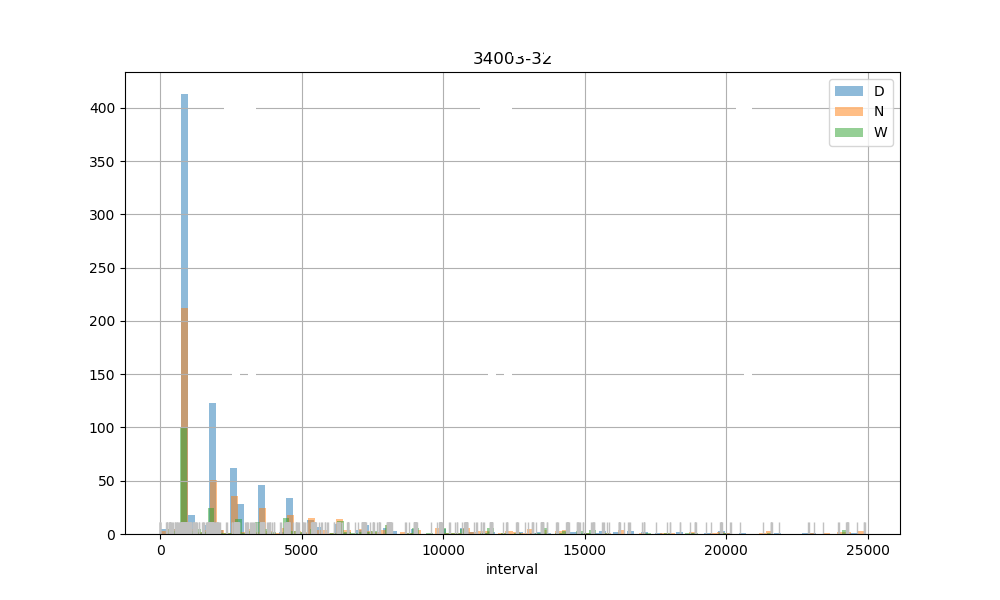

D count      862.00
mean      2780.20
std       3684.66
min          2.00
25%        899.00
50%       1005.00
75%       2715.00
max      24640.00
Name: interval, dtype: object
N count      539.00
mean      4219.45
std       5109.13
min          5.00
25%        904.00
50%       1809.00
75%       5411.00
max      24899.00
Name: interval, dtype: object
W count      296.00
mean      4792.94
std       5174.59
min        228.00
25%        906.75
50%       2699.00
75%       7201.00
max      24322.00
Name: interval, dtype: object


In [26]:
# show all the slots in one plot
fig = plt.figure()
ax = plt.subplot()
ax.grid(True, which='both')  # set a grid
fig.set_size_inches(10, 6)   # size of the full figure
rugkws={"height": .025, "color": "999999"}  # rug display parameters
histkws={"linewidth": 1, "alpha": 0.5}        # histogram display parameters

for name, group in by_slot:
    sns.distplot(group.interval, label=name, kde=False, bins=bins_to_use, hist_kws=histkws, rug=True, rug_kws=rugkws)
    # print the basic stats
    print(name, group["interval"].describe().apply(lambda x: format(x, '.2f')))

plt.title(agency)    # output the title
plt.legend()         # display a legend

<IPython.core.display.Javascript object>


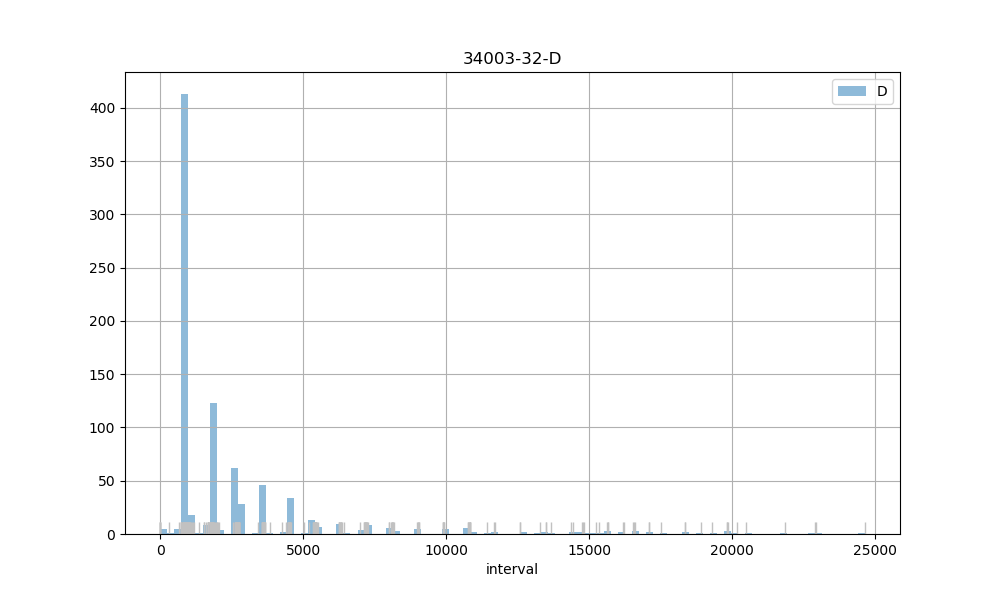

D count      862.00
mean      2780.20
std       3684.66
min          2.00
25%        899.00
50%       1005.00
75%       2715.00
max      24640.00
Name: interval, dtype: object


<IPython.core.display.Javascript object>


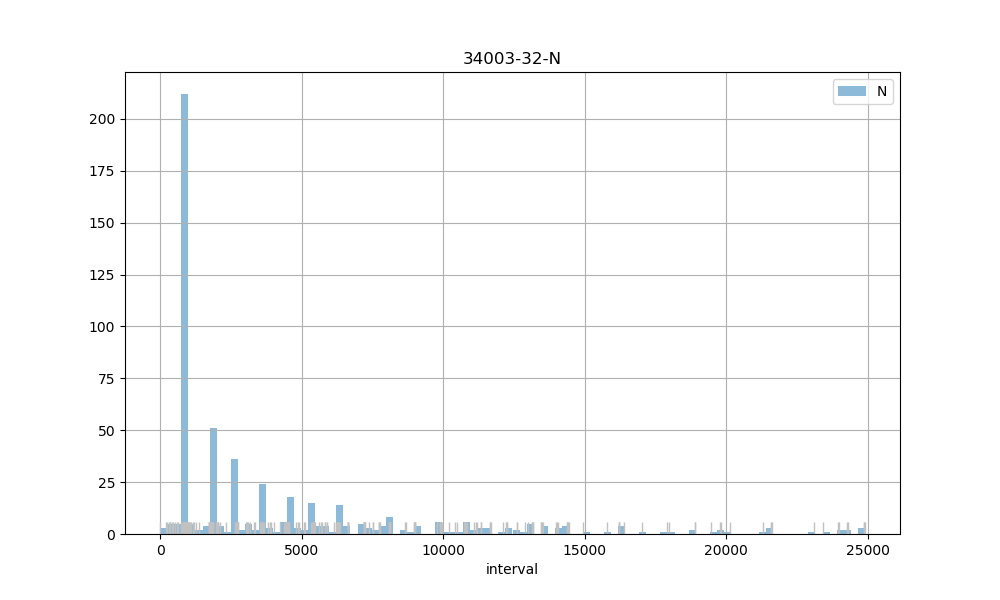

N count      539.00
mean      4219.45
std       5109.13
min          5.00
25%        904.00
50%       1809.00
75%       5411.00
max      24899.00
Name: interval, dtype: object


<IPython.core.display.Javascript object>


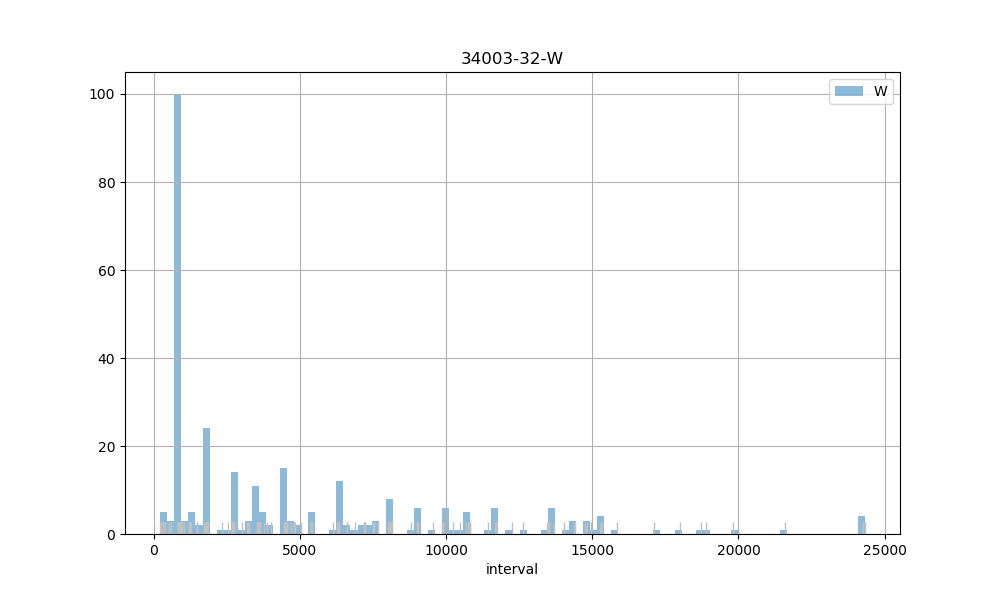

W count      296.00
mean      4792.94
std       5174.59
min        228.00
25%        906.75
50%       2699.00
75%       7201.00
max      24322.00
Name: interval, dtype: object


In [20]:
# show the slots in separate graphs 
for slot in list('DNW'):
    ddf = trimmed[trimmed.SLOT == slot]
    fig = plt.figure()
    ax = plt.subplot()
    ax.grid(True, which='both')  # set a grid
    fig.set_size_inches(10, 6)   # size of the full figure
    rugkws={"height": .025, "color": "999999"}  # rug display parameters
    histkws={"linewidth": 1, "alpha": 0.5}        # histogram display parameters

    sns.distplot(ddf.interval, label=slot, kde=False, bins=bins_to_use, hist_kws=histkws, rug=True, rug_kws=rugkws)
    # print the basic stats
    print(slot, ddf["interval"].describe().apply(lambda x: format(x, '.2f')))

    plt.title(agency + "-" + slot)    # output the title
    plt.legend()         # display a legend